# **Challenge Overview – Stock Agent**

Acting as consultants for an investment fund managing a portfolio of 11 stocks, your goal is to build an AI-powered solution that enhances investment decision-making. You may focus on the full portfolio or a specific subset. The aim is to demonstrate how AI can drive financial insights, whether through a trading agent, an analytical dashboard, or another innovative tool.
<br>
<br>
### **Tech & Tools**

It is mandatory to develop the solution in **Google Colab** using **Python**.

Other than that, you are completely free to choose your own:

•	Libraries and packages: Use any tool you need (e.g., Pandas, Scikit-learn, LangChain, etc.)

•	Visualization tools: Python-based tools (Matplotlib, Seaborn), Power BI, Tableau, etc. (if you use external visualization tools, don't forget to include prints in the submission zip folder)

•	AI assistants: Feel free to consult ChatGPT, GitHub Copilot, Gemini, or any other.
<br>
<br>
### **Tech Configuration**

**1** - The second code cell contains the code needed to export the dataset for the 11 assets. All data is saved as individual .csv files in a data/ directory, named according to the asset and frequency (e.g., AMZN_hourly.csv or AMZN_daily.csv).

**2** - The remaining cells include functions suggested by the dev team to help accelerate your solution. Each function comes with a description of its purpose and examples of expected usage. Feel free to use, adapt, extend, or completely rework them to fit your approach.

# Installs & Imports

In [23]:
%pip install protobuf==5.29.0 -q
%pip install yfinance==0.2.59 pandas==2.2.2 matplotlib==3.7.5 seaborn==0.13.2 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

2025-05-29 12:11:54.394364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 12:11:54.535003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 12:11:54.657887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-29 12:11:54.757980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-29 12:11:54.789133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 12:11:55.002456: I tensorflow/core/platform/cpu_feature_gu

**Data Fetching**

In [25]:
DATA_PATH = 'data/'

In [26]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os

# List of symbols to download
symbols = ["AMZN", "AAPL", "GOOGL", "MSFT", "UDMY", "NXE", "SPY",
           "CDR.WA", "EH", "BTC-USD", "ETH-USD"]

# Set date range
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print(f"Downloading hourly data from {start_str} to {end_str} (729 days)")

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Download data for each symbol
for symbol in symbols:
    print(f"\nDownloading hourly data for {symbol}...")

    try:
        # Download hourly data
        data = yf.download(symbol, start=start_str, end=end_str, interval="1h", progress=False)

        if not data.empty:
            # Reset index to make Datetime a column
            data.reset_index(inplace=True)

            # Save to CSV
            safe_name = symbol.replace('-', '_').replace('.', '_')
            filename = f"data/{safe_name}_hourly.csv"
            data.to_csv(filename, index=False)
            print(f"Successfully downloaded {len(data)} rows of hourly data for {symbol}")

            # Display the first 5 rows of data
            print(f"\nFirst 5 rows of {symbol} data:")
            print(data.head())

        else:
            print(f"No hourly data available for {symbol}")

            # Try daily data instead
            print(f"Attempting to download daily data for {symbol} instead...")
            daily_data = yf.download(symbol, start=(start_date - timedelta(days=365)).strftime('%Y-%m-%d'),
                                    end=end_str, interval="1d", progress=False)

            if not daily_data.empty:
                daily_data.reset_index(inplace=True)
                filename = f"data/{symbol.replace('-', '_').replace('.', '_')}_daily.csv"
                daily_data.to_csv(filename, index=False)
                print(f"Successfully downloaded {len(daily_data)} rows of daily data for {symbol}")

                # Display the first 5 rows of daily data
                print(f"\nFirst 5 rows of {symbol} daily data:")
                print(daily_data.head())
            else:
                print(f"Failed to download any data for {symbol}")

    except Exception as e:
        print(f"Error downloading data for {symbol}: {str(e)}")

# Create summary of downloaded files
file_info = []
for symbol in symbols:
    safe_name = symbol.replace('-', '_').replace('.', '_')
    hourly_path = f"data/{safe_name}_hourly.csv"
    daily_path = f"data/{safe_name}_daily.csv"

    if os.path.exists(hourly_path):
        df = pd.read_csv(hourly_path)
        file_info.append({
            'Symbol': symbol,
            'Filename': hourly_path,
            'Rows': len(df),
            'Start Date': df['Datetime'].iloc[0],
            'End Date': df['Datetime'].iloc[-1],
            'Frequency': 'Hourly'
        })
    elif os.path.exists(daily_path):
        df = pd.read_csv(daily_path)
        file_info.append({
            'Symbol': symbol,
            'Filename': daily_path,
            'Rows': len(df),
            'Start Date': df['Date'].iloc[0],
            'End Date': df['Date'].iloc[-1],
            'Frequency': 'Daily'
        })
    else:
        file_info.append({
            'Symbol': symbol,
            'Filename': 'N/A',
            'Rows': 0,
            'Start Date': 'N/A',
            'End Date': 'N/A',
            'Frequency': 'N/A'
        })

# Display file summary
file_summary = pd.DataFrame(file_info)
print("\nFile Summary:")
print(file_summary)

print("\nData collection complete!")


1 Failed download:
['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


No hourly data available for AMZN
Attempting to download daily data for AMZN instead...
Successfully downloaded 751 rows of daily data for AMZN

First 5 rows of AMZN daily data:
Price        Date       Close        High         Low        Open     Volume
Ticker                   AMZN        AMZN        AMZN        AMZN       AMZN
0      2022-05-31  120.209503  121.994499  115.675003  116.279999  144634000
1      2022-06-01  121.683998  125.179001  120.622498  122.255997  127528000
2      2022-06-02  125.511002  125.610001  120.044998  121.683998  100560000
3      2022-06-03  122.349998  124.400002  121.046501  124.199997   97604000
4      2022-06-06  124.790001  128.990005  123.809998  125.250000  135269000




1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


No hourly data available for AAPL
Attempting to download daily data for AAPL instead...
Successfully downloaded 751 rows of daily data for AAPL

First 5 rows of AAPL daily data:
Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2022-05-31  146.489822  148.281092  144.521402  146.716202  103718400
1      2022-06-01  146.361862  149.344017  145.348112  147.533059   74286600
2      2022-06-02  148.822418  148.881468  144.541098  145.495783   72348100
3      2022-06-03  143.084473  145.633573  142.179001  144.580461   88570300
4      2022-06-06  143.832458  146.224097  142.612033  144.708405   71598400

No hourly data available for GOOGL
Attempting to download daily data for GOOGL instead...



1 Failed download:
['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


Successfully downloaded 751 rows of daily data for GOOGL

First 5 rows of GOOGL daily data:
Price        Date       Close        High         Low        Open    Volume
Ticker                  GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
0      2022-05-31  113.220703  115.184315  111.545211  112.210032  50012000
1      2022-06-01  113.350075  116.544306  112.711131  114.308498  36606000
2      2022-06-02  117.062828  117.338510  112.409082  113.457567  37992000
3      2022-06-03  113.995995  115.768025  112.978361  115.510255  26136000
4      2022-06-06  116.264641  118.779116  115.611263  116.149188  33542000

No hourly data available for MSFT
Attempting to download daily data for MSFT instead...
Successfully downloaded 751 rows of daily data for MSFT

First 5 rows of MSFT daily data:
Price        Date       Close        High         Low        Open    Volume
Ticker                   MSFT        MSFT        MSFT        MSFT      MSFT
0      2022-05-31  265.144257  267.972508  26


1 Failed download:
['UDMY']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


No hourly data available for UDMY
Attempting to download daily data for UDMY instead...



1 Failed download:
['NXE']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')

1 Failed download:
['SPY']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


Successfully downloaded 751 rows of daily data for UDMY

First 5 rows of UDMY daily data:
Price        Date  Close   High     Low   Open   Volume
Ticker              UDMY   UDMY    UDMY   UDMY     UDMY
0      2022-05-31  14.75  15.96  14.360  15.69  1177100
1      2022-06-01  13.45  14.92  13.370  14.59  1331000
2      2022-06-02  14.00  14.21  13.070  13.39  1407000
3      2022-06-03  14.27  14.39  13.325  13.85  1066300
4      2022-06-06  13.46  14.97  13.410  14.58  1088100

No hourly data available for NXE
Attempting to download daily data for NXE instead...
Successfully downloaded 751 rows of daily data for NXE

First 5 rows of NXE daily data:
Price        Date Close   High   Low  Open   Volume
Ticker              NXE    NXE   NXE   NXE      NXE
0      2022-05-31  4.75  5.030  4.66  4.98  2737700
1      2022-06-01  4.43  4.845  4.43  4.80  2493000
2      2022-06-02  4.85  4.900  4.45  4.45  2728800
3      2022-06-03  4.69  4.810  4.63  4.77  1992400
4      2022-06-06  4.68  4.820 


1 Failed download:
['CDR.WA']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685397600 and endTime=1748469600. The requested range must be within the last 730 days.")')


Successfully downloaded 751 rows of daily data for SPY

First 5 rows of SPY daily data:
Price        Date       Close        High         Low        Open    Volume
Ticker                    SPY         SPY         SPY         SPY       SPY
0      2022-05-31  395.224152  398.602789  392.448505  395.817562  95937000
1      2022-06-01  392.027374  398.392226  389.481428  397.368128  86585800
2      2022-06-02  399.492920  399.540764  389.586707  391.864661  79609600
3      2022-06-03  392.936646  396.286571  391.950812  394.716877  71874300
4      2022-06-06  394.133026  398.746329  392.946176  396.994810  57508900

No hourly data available for CDR.WA
Attempting to download daily data for CDR.WA instead...
Successfully downloaded 750 rows of daily data for CDR.WA

First 5 rows of CDR.WA daily data:
Price        Date       Close        High         Low        Open   Volume
Ticker                 CDR.WA      CDR.WA      CDR.WA      CDR.WA   CDR.WA
0      2022-05-30  110.276230  115.034396  


1 Failed download:
['EH']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685419200 and endTime=1748491200. The requested range must be within the last 730 days.")')


No hourly data available for EH
Attempting to download daily data for EH instead...
Successfully downloaded 751 rows of daily data for EH

First 5 rows of EH daily data:
Price        Date Close  High   Low  Open   Volume
Ticker               EH    EH    EH    EH       EH
0      2022-05-31  8.92  9.24  8.00  8.50  1139300
1      2022-06-01  9.04  9.16  8.73  8.99   459000
2      2022-06-02  9.20  9.33  8.95  9.04   512100
3      2022-06-03  9.05  9.16  8.88  9.08   264800
4      2022-06-06  9.36  9.69  9.19  9.34   554100




1 Failed download:
['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685404800 and endTime=1748476800. The requested range must be within the last 730 days.")')


No hourly data available for BTC-USD
Attempting to download daily data for BTC-USD instead...
Successfully downloaded 1095 rows of daily data for BTC-USD

First 5 rows of BTC-USD daily data:
Price        Date         Close          High           Low          Open  \
Ticker                  BTC-USD       BTC-USD       BTC-USD       BTC-USD   
0      2022-05-30  31726.390625  31949.630859  29303.572266  29443.365234   
1      2022-05-31  31792.310547  32249.863281  31286.154297  31723.865234   
2      2022-06-01  29799.080078  31957.285156  29501.587891  31792.554688   
3      2022-06-02  30467.488281  30604.734375  29652.705078  29794.890625   
4      2022-06-03  29704.390625  30633.035156  29375.689453  30467.806641   

Price        Volume  
Ticker      BTC-USD  
0       39277993274  
1       33538210634  
2       41135817341  
3       29083562061  
4       26175547452  




1 Failed download:
['ETH-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-05-30 -> 2025-05-29) (Yahoo error = "1h data not available for startTime=1685404800 and endTime=1748476800. The requested range must be within the last 730 days.")')


No hourly data available for ETH-USD
Attempting to download daily data for ETH-USD instead...
Successfully downloaded 1095 rows of daily data for ETH-USD

First 5 rows of ETH-USD daily data:
Price        Date        Close         High          Low         Open  \
Ticker                 ETH-USD      ETH-USD      ETH-USD      ETH-USD   
0      2022-05-30  1996.441284  2005.210815  1804.456055  1811.885986   
1      2022-05-31  1942.328003  2005.490967  1932.352051  1996.408081   
2      2022-06-01  1823.569336  1965.166626  1776.053223  1942.050659   
3      2022-06-02  1834.150513  1845.313965  1789.664185  1822.412109   
4      2022-06-03  1775.078613  1840.058838  1746.509766  1834.135010   

Price        Volume  
Ticker      ETH-USD  
0       19580808705  
1       18363115560  
2       21037797760  
3       17065041354  
4       14878001811  

File Summary:
     Symbol                 Filename   Rows  Start Date  \
0      AMZN     data/AMZN_hourly.csv   3481         NaN   
1      AAP

**Possible Implementation Ideas**

In [39]:
def explore_data(data, symbol_name=None, ma_periods=[20, 50]):
    """Generate basic statistics and visualizations of the market data with moving averages."""
    
    # Print basic info about the dataset
    print(f"Dataset Info for {symbol_name if symbol_name else 'Stock'}:")
    print(f"Shape: {data.shape}")
    print(f"Date range: {data.iloc[0, 0]} to {data.iloc[-1, 0]}")
    print("\nSummary Statistics:")
    print(data.describe())
    
    # Determine the datetime column name
    datetime_col = 'Datetime' if 'Datetime' in data.columns else 'Date'
    
    # Convert datetime column to datetime type if it's not already
    data[datetime_col] = pd.to_datetime(data[datetime_col])
    
    # Calculate moving averages for closing price
    for period in ma_periods:
        data[f'MA_{period}'] = data['Close'].rolling(window=period).mean()
    
    # Calculate moving average for volume
    volume_ma_period = ma_periods[0]  # Use first MA period for volume
    data[f'Volume_MA_{volume_ma_period}'] = data['Volume'].rolling(window=volume_ma_period).mean()
    
    # Create subplots - 2 rows, 1 column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Closing Price over time with moving averages
    ax1.plot(data[datetime_col], data['Close'], color='blue', linewidth=1, label='Close Price')
    
    # Add moving averages to price chart
    colors = ['red', 'orange', 'purple', 'brown']
    for i, period in enumerate(ma_periods):
        color = colors[i % len(colors)]
        ax1.plot(data[datetime_col], data[f'MA_{period}'], 
                color=color, linewidth=1.5, alpha=0.8, label=f'MA {period}')
    
    ax1.set_title(f'{symbol_name if symbol_name else "Stock"} - Closing Price Over Time with Moving Averages', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price ($)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')
    
    # Plot 2: Volume over time with moving average
    ax2.plot(data[datetime_col], data['Volume'], color='green', linewidth=1, alpha=0.7, label='Volume')
    ax2.plot(data[datetime_col], data[f'Volume_MA_{volume_ma_period}'], 
            color='darkgreen', linewidth=2, label=f'Volume MA {volume_ma_period}')
    
    ax2.set_title(f'{symbol_name if symbol_name else "Stock"} - Volume Over Time with Moving Average', 
                 fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(loc='upper left')
    
    # Format y-axis for volume to show in millions/billions
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.1f}K'))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    # Print additional insights including moving averages
    print(f"Key Insights:")
    print(f"Highest closing price: ${data['Close'].max():.2f}")
    print(f"Lowest closing price: ${data['Close'].min():.2f}")
    print(f"Average closing price: ${data['Close'].mean():.2f}")
    print(f"Current MA {ma_periods[0]}: ${data[f'MA_{ma_periods[0]}'].iloc[-1]:.2f}")
    print(f"Current MA {ma_periods[1]}: ${data[f'MA_{ma_periods[1]}'].iloc[-1]:.2f}")
    print(f"Highest volume: {data['Volume'].max():,}")
    print(f"Average volume: {data['Volume'].mean():,.0f}")
    print(f"Current Volume MA {volume_ma_period}: {data[f'Volume_MA_{volume_ma_period}'].iloc[-1]:,.0f}")
    
    return None

Dataset Info for Amazon (AMZN):
Shape: (3480, 6)
Date range: 2023-05-31 13:30:00+00:00 to 2025-05-28 19:30:00+00:00

Summary Statistics:
             Close         High          Low         Open        Volume
count  3480.000000  3480.000000  3480.000000  3480.000000  3.480000e+03
mean    174.281643   174.965471   173.567294   174.271888  5.320158e+06
std      30.826220    30.941780    30.702158    30.830435  3.981511e+06
min     118.779999   119.245003   118.349998   118.779999  0.000000e+00
25%     145.637505   146.267502   145.193752   145.534996  3.019543e+06
50%     179.487495   180.014999   178.726151   179.547997  4.145516e+06
75%     192.998798   193.762497   192.217506   193.032505  6.110136e+06
max     242.449799   242.520004   241.550003   242.440002  5.913629e+07


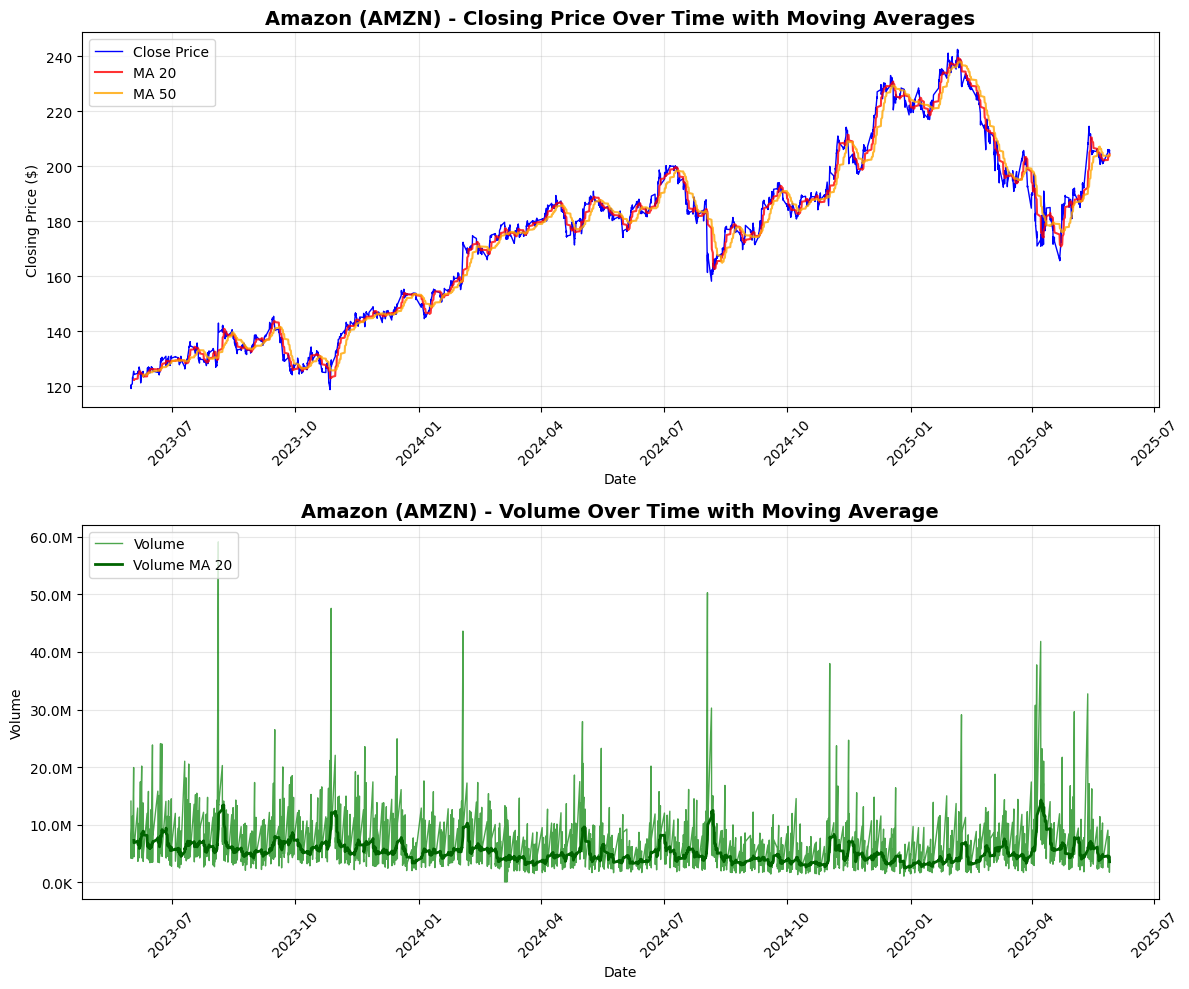

Key Insights:
Highest closing price: $242.45
Lowest closing price: $118.78
Average closing price: $174.28
Current MA 20: $204.32
Current MA 50: $203.90
Highest volume: 59,136,286
Average volume: 5,320,158
Current Volume MA 20: 3,549,261


In [40]:
amzn_data = pd.read_csv(DATA_PATH + 'AMZN_hourly.csv', skiprows=[1])
explore_data(amzn_data, symbol_name='Amazon (AMZN)')

In [29]:
# Visualize technical indicators
def visualize_indicators(data):
    """Add and plot technical indicators like SMA, EMA, RSI, etc."""
    # Example steps:
    # - Compute simple and exponential moving averages
    # - Plot with the original closing price
    # - Highlight crossover points

    return None


In [ ]:
def prepare_data(data):
    

In [ ]:
# Perform ML Analysis to identify trends and make predictions
def analyze_market_trends(market_data):
    """Apply ML techniques to analyze stock/crypto trends."""
    # Example steps:
    # - Normalize data for better trend detection
    # - Apply time series models (ARIMA, LSTMs, etc.)
    # - Identify market linearity and anomalies
    # - Predict future price movements

    
    

    return {}


In [31]:
# Generate trading signals based on strategy
def generate_trading_signals(data):
    """Define and apply rules to generate buy/sell signals."""
    # Example strategy ideas:
    # - SMA crossover
    # - RSI-based entry/exit
    # - Price breakout detection

    return []


In [32]:
# Simulate portfolio performance
def simulate_portfolio(data, signals):
    """Backtest the strategy using historical data and generated signals."""
    # Example steps:
    # - Initialize a virtual portfolio
    # - Buy/sell based on signals
    # - Track cumulative returns and drawdowns

    return {}


In [33]:
# Evaluate strategy performance
def evaluate_strategy(results):
    """Evaluate strategy using key metrics."""
    # Example metrics:
    # - Cumulative returns
    # - Sharpe ratio
    # - Maximum drawdown

    return {}


In [34]:
# Wrap-up and discussion
def reflect_on_findings():
    """Summarize insights and propose next steps."""
    # Example:
    # - What worked? What didn’t?
    # - How would you improve the strategy?
    # - What other data might help?

    return None
